<div style="border-radius:10px;
            border:#0b0265 solid;
           background-color:#ace600;
           font-size:110%;
           letter-spacing:0.5px;
            text-align: center">

<center><h1 style="padding: 25px 0px; color:#0b0265; font-weight: bold; font-family: Cursive">
CNN From Scratch</h1></center>

</div>

In this project, we will implement convolutional (CONV) and pooling (POOL) layers in numpy, including both forward propagation and backward propagation. 

By the end of this notebook, you'll be able to: 

**Notation**:
- Superscript $[l]$ denotes an object of the $l^{th}$ layer. 
    - Example: $a^{[4]}$ is the $4^{th}$ layer activation. $W^{[5]}$ and $b^{[5]}$ are the $5^{th}$ layer parameters.


- Superscript $(i)$ denotes an object from the $i^{th}$ example. 
    - Example: $x^{(i)}$ is the $i^{th}$ training example input.
    
    
- Subscript $i$ denotes the $i^{th}$ entry of a vector.
    - Example: $a^{[l]}_i$ denotes the $i^{th}$ entry of the activations in layer $l$, assuming this is a fully connected (FC) layer.
    
    
- $n_H$, $n_W$ and $n_C$ denote respectively the height, width and number of channels of a given layer. If you want to reference a specific layer $l$, you can also write $n_H^{[l]}$, $n_W^{[l]}$, $n_C^{[l]}$. 
- $n_{H_{prev}}$, $n_{W_{prev}}$ and $n_{C_{prev}}$ denote respectively the height, width and number of channels of the previous layer. If referencing a specific layer $l$, this could also be denoted $n_H^{[l-1]}$, $n_W^{[l-1]}$, $n_C^{[l-1]}$.

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

np.random.seed(1)

**Outline of the Project:**

We will be implementing the building blocks of a convolutional neural network:

- Convolution functions, including:
    - Zero Padding
    - Convolve window 
    - Convolution forward
    - Convolution backward
- Pooling functions, including:
    - Pooling forward
    - Create mask 
    - Distribute value
    - Pooling backward
    
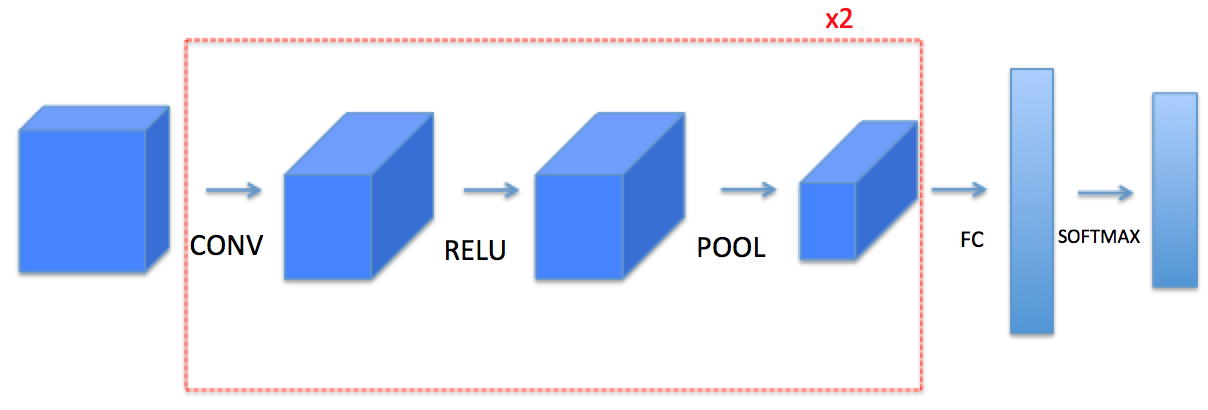

**Note**: For every forward function, there is a corresponding backward equivalent. Hence, at every step of our forward module we will store some parameters in a cache. These parameters are used to compute gradients during backpropagation. 

A convolution layer transforms an input volume into an output volume of different size, as shown below.

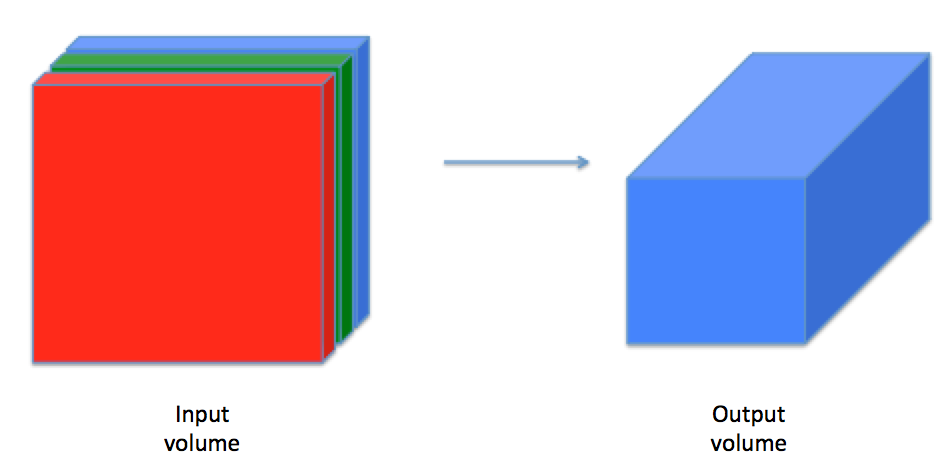

**Zero-Padding:**

Zero-padding adds zeros around the border of an image:

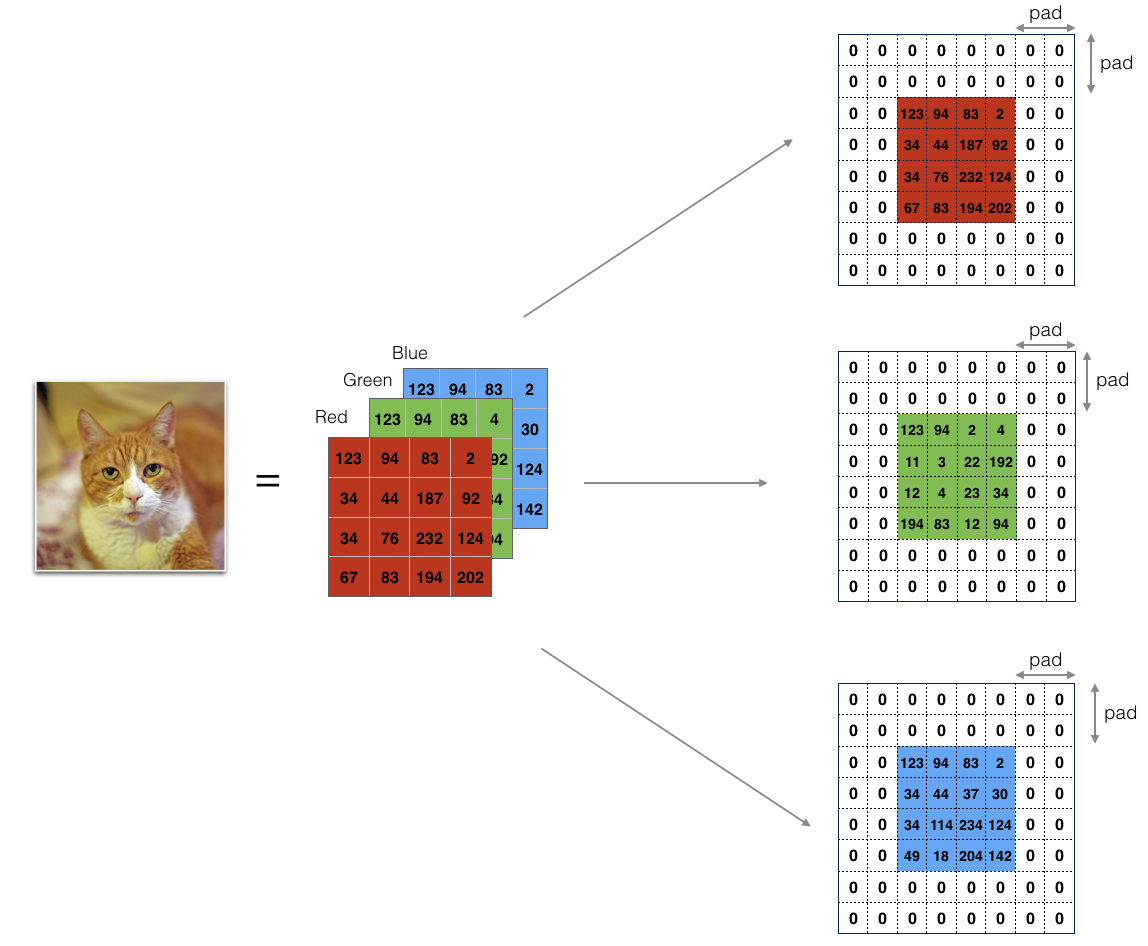

The main benefits of padding are:

- It allows you to use a CONV layer without necessarily shrinking the height and width of the volumes. This is important for building deeper networks, since otherwise the height/width would shrink as you go to deeper layers. An important special case is the "same" convolution, in which the height/width is exactly preserved after one layer. 

- It helps us keep more of the information at the border of an image. Without padding, very few values at the next layer would be affected by pixels at the edges of an image.

We [Use np.pad](https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html). Note if we want to pad the array "a" of shape $(5,5,5,5,5)$ with `pad = 1` for the 2nd dimension, `pad = 3` for the 4th dimension and `pad = 0` for the rest, we would do:
```python
a = np.pad(a, ((0,0), (1,1), (0,0), (3,3), (0,0)), mode='constant', constant_values = (0,0))
```

In [2]:
def zero_pad(X, pad):
    """
    Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image, 
    as illustrated in Figure 1.
    
    Argument:                       apply only on n_H, n_W
    X -- python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
    pad -- integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
    X_pad -- padded image of shape (m, n_H + 2 * pad, n_W + 2 * pad, n_C)
    """
    X_pad = np.pad(X,((0,0),(pad,pad),(pad,pad),(0,0)))
    
    return X_pad

x.shape =
 (4, 3, 3, 2)
x_pad.shape =
 (4, 9, 9, 2)
x[1,1] =
 [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] =
 [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


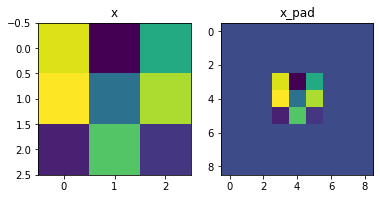

In [6]:
#Example of a zero padding

np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 3)
print ('x.shape =\n', x.shape)
print ('x_pad.shape =\n', x_pad.shape)
print ('x[1,1] =\n', x[1, 1])
print ('x_pad[1,1] =\n', x_pad[1, 1])

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0, :, :, 0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0, :, :, 0]);

**Single Step of Convolution:**

In this part, we implement a single step of convolution, in which we apply the filter to a single position of the input. This will be used to build a convolutional unit, which: 

- Takes an input volume 
- Applies a filter at every position of the input
- Outputs another volume (usually of different size)

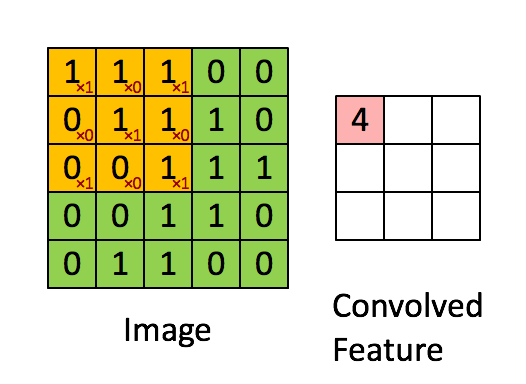

In a computer vision application, each value in the matrix on the left corresponds to a single pixel value. We convolve a 3x3 filter with the image by multiplying its values element-wise with the original matrix, then summing them up and adding a bias. In this first step of the exercise, we will implement a single step of convolution, corresponding to applying a filter to just one of the positions to get a single real-valued output. 

In [ ]:
def conv_single_step(a_slice_prev, W, b):
    """
    Apply one filter defined by parameters W on a single slice (a_slice_prev) of the output activation 
    of the previous layer.
    
    Arguments:
    a_slice_prev -- slice of input data of shape (f, f, n_C_prev)
    W -- Weight parameters contained in a window - matrix of shape (f, f, n_C_prev)
    b -- Bias parameters contained in a window - matrix of shape (1, 1, 1)
    
    Returns:
    Z -- a scalar value, the result of convolving the sliding window (W, b) on a slice x of the input data
    """
    #Element-wise product between a_slice_prev and W. Do not add the bias yet.
    s = np.multiply(a_slice_prev,W)
    #Sum over all entries of the volume s.
    Z = np.sum(s)
    b = np.squeeze(b)
    #Add bias b to Z.
    Z = Z + b

    return Z

**CNN - Forward Pass:**

In the forward pass, we will take many filters and convolve them on the input. Each 'convolution' gives us a 2D matrix output. We will then stack these outputs to get a 3D volume.

The formulas relating the output shape of the convolution to the input shape are:
    
$$n_H = \Bigl\lfloor \frac{n_{H_{prev}} - f + 2 \times pad}{stride} \Bigr\rfloor +1$$
$$n_W = \Bigl\lfloor \frac{n_{W_{prev}} - f + 2 \times pad}{stride} \Bigr\rfloor +1$$
$$n_C = \text{number of filters used in the convolution}$$


1. To select a 2x2 slice at the upper left corner of a matrix "a_prev" (shape (5,5,3)), we would do:
```python
a_slice_prev = a_prev[0:2,0:2,:]
```
Notice how this gives a 3D slice that has height 2, width 2, and depth 3.  Depth is the number of channels.  
This will be useful when we will define `a_slice_prev` below, using the `start/end` indexes we will define.

2. To define a_slice we will need to first define its corners `vert_start`, `vert_end`, `horiz_start` and `horiz_end`. This figure may be helpful for us to find out how each of the corners can be defined using h, w, f and s in the code below.

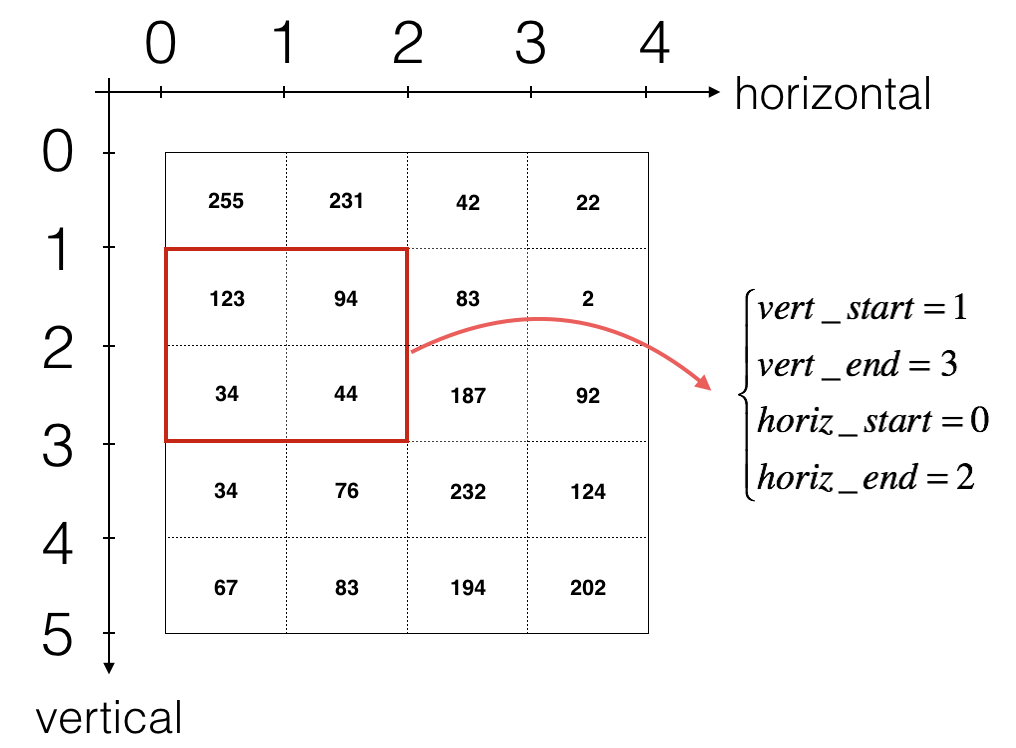



In [7]:
def conv_forward(A_prev, W, b, hparameters):
    """
    Implements the forward propagation for a convolution function
    
    Arguments:
    A_prev -- output activations of the previous layer, 
        numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- python dictionary containing "stride" and "pad"
        
    Returns:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward() function
    """  
    #Retrieve dimensions from A_prev's shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    #Retrieve dimensions from W's shape
    (f, f, n_C_prev, n_C) = W.shape
    
    #Retrieve information from "hparameters"
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    #Compute the dimensions of the CONV output volume using the formula given above.
    n_H = int((n_H_prev + 2*pad - f)/stride) + 1
    n_W = int((n_W_prev + 2*pad - f)/stride) + 1
    
    #Initialize the output volume Z with zeros.
    Z = np.zeros((m, n_H, n_W, n_C))
    
    #Create A_prev_pad by padding A_prev
    A_prev_pad = zero_pad(A_prev, pad)
    
    #Loop over the batch of training examples
    for i in range(m):
        #Select ith training example's padded activation
        a_prev_pad = A_prev_pad[i]
        #Loop over vertical axis of the output volume
        for h in range(n_H):
            #Find the vertical start and end of the current "slice"
            vert_start = stride * h 
            vert_end = vert_start  + f
            #Loop over horizontal axis of the output volume
            for w in range(n_W):
                #Find the horizontal start and end of the current "slice"
                horiz_start = stride * w
                horiz_end = horiz_start + f
                #Loop over channels (= #filters) of the output volume
                for c in range(n_C):
                    #Use the corners to define the (3D) slice of a_prev_pad (See Hint above the cell).
                    a_slice_prev = a_prev_pad[vert_start:vert_end,
                                              horiz_start:horiz_end
                                              ,:]
                    #Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron.
                    weights = W[:, :, :, c]
                    biases  = b[:, :, :, c]
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, weights, biases)

    #Making sure your output shape is correct
    assert(Z.shape == (m, n_H, n_W, n_C))

    #Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

**Pooling Layer:**

The pooling (POOL) layer reduces the height and width of the input. It helps reduce computation, as well as helps make feature detectors more invariant to its position in the input. The two types of pooling layers are: 

- Max-pooling layer: slides an ($f, f$) window over the input and stores the max value of the window in the output.

- Average-pooling layer: slides an ($f, f$) window over the input and stores the average value of the window in the output.

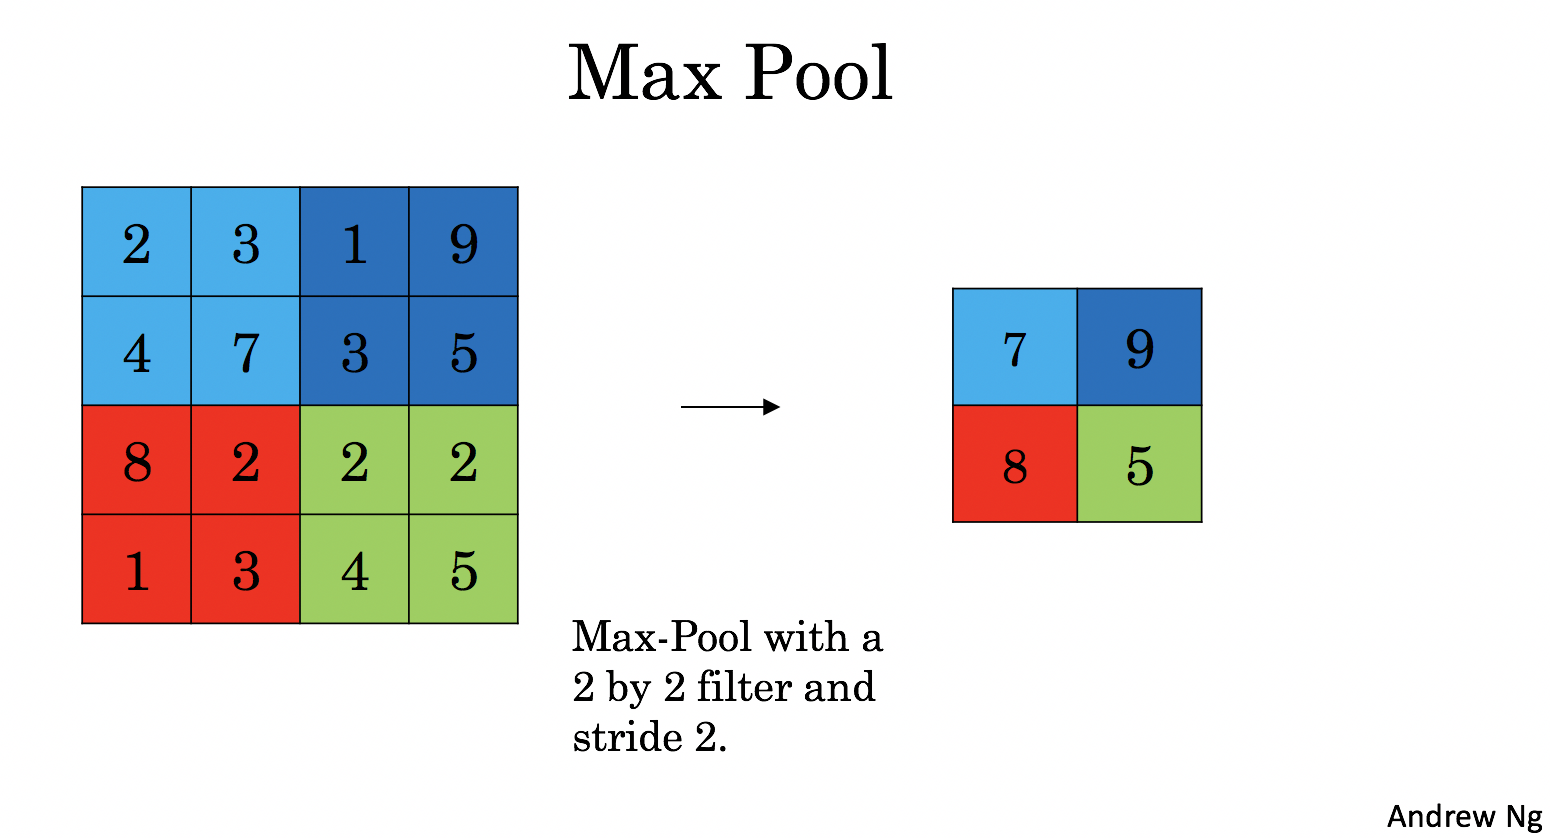

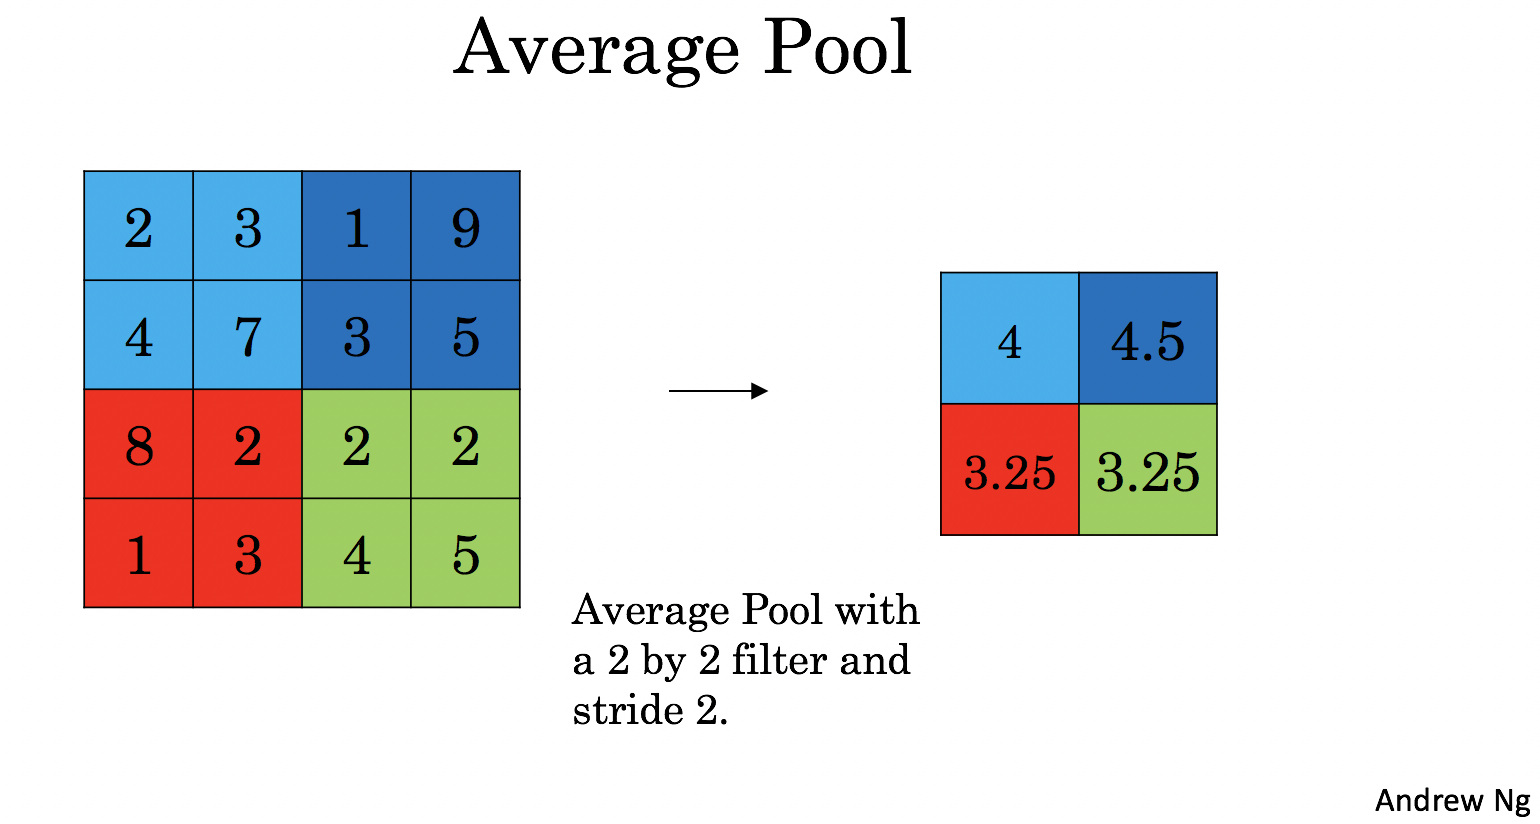

These pooling layers have no parameters for backpropagation to train. However, they have hyperparameters such as the window size $f$. This specifies the height and width of the $f \times f$ window we would compute a *max* or *average* over. 

**Reminder**:
As there's no padding, the formulas binding the output shape of the pooling to the input shape is:

$$n_H = \Bigl\lfloor \frac{n_{H_{prev}} - f}{stride} \Bigr\rfloor +1$$

$$n_W = \Bigl\lfloor \frac{n_{W_{prev}} - f}{stride} \Bigr\rfloor +1$$

$$n_C = n_{C_{prev}}$$

In [8]:
def pool_forward(A_prev, hparameters, mode = "max"):
    """
    Implements the forward pass of the pooling layer
    
    Arguments:
    A_prev -- Input data, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    hparameters -- python dictionary containing "f" and "stride"
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    A -- output of the pool layer, a numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache used in the backward pass of the pooling layer, contains the input and hparameters 
    """   
    #Retrieve dimensions from the input shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    #Retrieve hyperparameters from "hparameters"
    f = hparameters['f']
    stride = hparameters['stride']
    
    #Define the dimensions of the output
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    #Initialize output matrix A
    A = np.zeros((m, n_H, n_W, n_C))              
    
    #Loop over the training examples
    for i in range(m):
        a_prev_slice = A_prev[i]
        #Loop on the vertical axis of the output volume
        for h in range(n_H):
            #Find the vertical start and end of the current "slice"
            vert_start = stride * h 
            vert_end = vert_start + f
            #Loop on the horizontal axis of the output volume
            for w in range(n_W):
                #Find the vertical start and end of the current "slice"
                horiz_start = stride * w
                horiz_end = horiz_start + f
                #Lloop over the channels of the output volume
                for c in range (n_C):
                    #Use the corners to define the current slice on the ith training example of A_prev, channel c.
                    a_slice_prev = a_prev_slice[vert_start:vert_end,
                                                horiz_start:horiz_end,
                                                c]
                    #Compute the pooling operation on the slice. 
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_slice_prev)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_slice_prev)
                    else:
                        print(mode+ "-type pooling layer NOT Defined") 
    
    #Store the input and hparameters in "cache" for pool_backward()
    cache = (A_prev, hparameters)
    
    #Making sure your output shape is correct
    assert(A.shape == (m, n_H, n_W, n_C))
    
    return A, cache

**Backpropagation in CNN:**

In modern deep learning frameworks, we only have to implement the forward pass, and the framework takes care of the backward pass, so most deep learning engineers don't need to bother with the details of the backward pass. 

In convolutional neural networks we can calculate the derivatives with respect to the cost in order to update the parameters. The backprop equations are presented below.

- Computing dA:

This is the formula for computing $dA$ with respect to the cost for a certain filter $W_c$ and a given training example:

$$dA \mathrel{+}= \sum _{h=0} ^{n_H} \sum_{w=0} ^{n_W} W_c \times dZ_{hw} \tag{1}$$

Where $W_c$ is a filter and $dZ_{hw}$ is a scalar corresponding to the gradient of the cost with respect to the output of the conv layer Z at the hth row and wth column (corresponding to the dot product taken at the ith stride left and jth stride down). Note that at each time, we multiply the the same filter $W_c$ by a different dZ when updating dA. We do so mainly because when computing the forward propagation, each filter is dotted and summed by a different a_slice. Therefore when computing the backprop for dA, we are just adding the gradients of all the a_slices. 

In code, inside the appropriate for-loops, this formula translates into:
```python
da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
```

- Computing dW:
This is the formula for computing $dW_c$ ($dW_c$ is the derivative of one filter) with respect to the loss:

$$dW_c  \mathrel{+}= \sum _{h=0} ^{n_H} \sum_{w=0} ^ {n_W} a_{slice} \times dZ_{hw}  \tag{2}$$

Where $a_{slice}$ corresponds to the slice which was used to generate the activation $Z_{ij}$. Hence, this ends up giving us the gradient for $W$ with respect to that slice. Since it is the same $W$, we will just add up all such gradients to get $dW$. 

In code, inside the appropriate for-loops, this formula translates into:
```python
dW[:,:,:,c] \mathrel{+}= a_slice * dZ[i, h, w, c]
```

- Computing db:

This is the formula for computing $db$ with respect to the cost for a certain filter $W_c$:

$$db = \sum_h \sum_w dZ_{hw} \tag{3}$$

As we have previously seen in basic neural networks, db is computed by summing $dZ$. In this case, we are just summing over all the gradients of the conv output (Z) with respect to the cost. 

In code, inside the appropriate for-loops, this formula translates into:
```python
db[:,:,:,c] += dZ[i, h, w, c]
```

In [9]:
def conv_backward(dZ, cache):
    """
    Implement the backward propagation for a convolution function
    
    Arguments:
    dZ -- gradient of the cost with respect to the output of the conv layer (Z), numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward(), output of conv_forward()
    
    Returns:
    dA_prev -- gradient of the cost with respect to the input of the conv layer (A_prev),
               numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    dW -- gradient of the cost with respect to the weights of the conv layer (W)
          numpy array of shape (f, f, n_C_prev, n_C)
    db -- gradient of the cost with respect to the biases of the conv layer (b)
          numpy array of shape (1, 1, 1, n_C)
    """  
    #Retrieve information from "cache"
    (A_prev, W, b, hparameters) = cache
    #Retrieve dimensions from A_prev's shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    #Retrieve dimensions from W's shape
    (f, f, n_C_prev, n_C) = W.shape
    #Retrieve information from "hparameters"
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    #Retrieve dimensions from dZ's shape
    (m, n_H, n_W, n_C) = dZ.shape
    #Initialize dA_prev, dW, db with the correct shapes
    dA_prev = np.zeros(A_prev.shape)                          
    dW = np.zeros(W.shape)
    db = np.zeros(b.shape) # b.shape = [1,1,1,n_C]
    #Pad A_prev and dA_prev
    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)
    #Loop over the training examples
    for i in range(m):
        #Select ith training example from A_prev_pad and dA_prev_pad
        a_prev_pad = A_prev_pad[i]
        da_prev_pad = dA_prev_pad[i]

        #Loop over vertical axis of the output volume     
        for h in range(n_H):
            #Loop over horizontal axis of the output volume                   
            for w in range(n_W):
                #Loop over the channels of the output volume
                for c in range(n_C):
                    #Find the corners of the current "slice"
                    vert_start = stride * h 
                    vert_end = vert_start + f
                    horiz_start = stride * w
                    horiz_end = horiz_start + f
                    #Use the corners to define the slice from a_prev_pad
                    a_slice = a_prev_pad[vert_start:vert_end,
                                         horiz_start:horiz_end,
                                         :]
                    #Update gradients for the window and the filter's parameters using the code formulas given above
                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
                    dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
                    db[:,:,:,c] += dZ[i, h, w, c]
        #Set the ith training example's dA_prev to the unpadded da_prev_pad (Hint: use X[pad:-pad, pad:-pad, :])
        dA_prev[i, :, :, :] = da_prev_pad[pad:-pad, pad:-pad, :]

    #Making sure your output shape is correct
    assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))
    
    return dA_prev, dW, db

**Pooling Layer - Backward Pass:**

Next, let's implement the backward pass for the pooling layer, starting with the MAX-POOL layer. Even though a pooling layer has no parameters for backprop to update, we still need to backpropagate the gradient through the pooling layer in order to compute gradients for layers that came before the pooling layer.

Before jumping into the backpropagation of the pooling layer, we are going to build a helper function called `create_mask_from_window()` which does the following: 

$$ X = \begin{bmatrix}
1 && 3 \\
4 && 2
\end{bmatrix} \quad \rightarrow  \quad M =\begin{bmatrix}
0 && 0 \\
1 && 0
\end{bmatrix}\tag{4}$$

As we can see, this function creates a "mask" matrix which keeps track of where the maximum of the matrix is. True (1) indicates the position of the maximum in X, the other entries are False (0). You'll see later that the backward pass for average pooling is similar to this, but uses a different mask.

In [10]:
def create_mask_from_window(x):
    """
    Creates a mask from an input matrix x, to identify the max entry of x.
    
    Arguments:
    x -- Array of shape (f, f)
    
    Returns:
    mask -- Array of the same shape as window, contains a True at the position corresponding to the max entry of x.
    """    
    mask = (x == np.max(x))
    
    return mask

**Average Pooling - Backward Pass:**

In max pooling, for each input window, all the "influence" on the output came from a single input value--the max. In average pooling, every element of the input window has equal influence on the output. So to implement backprop, we will now implement a helper function that reflects this.

For example if we did average pooling in the forward pass using a 2x2 filter, then the mask we'll use for the backward pass will look like: 
$$ dZ = 1 \quad \rightarrow  \quad dZ =\begin{bmatrix}
1/4 && 1/4 \\
1/4 && 1/4
\end{bmatrix}\tag{5}$$

This implies that each position in the $dZ$ matrix contributes equally to output because in the forward pass, we took an average. 

In [11]:
def distribute_value(dz, shape):
    """
    Distributes the input value in the matrix of dimension shape
    
    Arguments:
    dz -- input scalar
    shape -- the shape (n_H, n_W) of the output matrix for which we want to distribute the value of dz
    
    Returns:
    a -- Array of size (n_H, n_W) for which we distributed the value of dz
    """    
    #Retrieve dimensions from shape
    (n_H, n_W) = shape
    #Compute the value to distribute on the matrix
    average = np.prod(shape)
    #Create a matrix where every entry is the "average" value
    a = (dz/average)*np.ones(shape)
    
    return a

**Pool Backward:**

In [14]:
def pool_backward(dA, cache, mode = 'max'):
    """
    Implements the backward pass of the pooling layer
    
    Arguments:
    dA -- gradient of cost with respect to the output of the pooling layer, same shape as A
    cache -- cache output from the forward pass of the pooling layer, contains the layer's input and hparameters 
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    dA_prev -- gradient of cost with respect to the input of the pooling layer, same shape as A_prev
    """
    #Retrieve information from cache
    (A_prev, hparameters) = cache
    
    #Retrieve hyperparameters from "hparameters"
    stride = hparameters['stride']
    f = hparameters['f']
    
    #Retrieve dimensions from A_prev's shape and dA's shape
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    m, n_H, n_W, n_C = dA.shape
    
    #Initialize dA_prev with zeros
    dA_prev = np.zeros(A_prev.shape)
    
    for i in range(m):                         #Loop over the training examples
        #Select training example from A_prev
        a_prev = A_prev[i]
        for h in range(n_H):                   #Loop on the vertical axis
            for w in range(n_W):               #Loop on the horizontal axis
                for c in range(n_C):           #Loop over the channels (depth)
                    #Find the corners of the current "slice"
                    vert_start = h
                    vert_end = vert_start + f
                    horiz_start = w
                    horiz_end = horiz_start + f
                    
                    #Compute the backward propagation in both modes.
                    if mode == 'max':
                        #Use the corners and "c" to define the current slice from a_prev
                        a_prev_slice = a_prev[vert_start:vert_end, horiz_start:horiz_end, c]
                        #Create the mask from a_prev_slice (≈1 line)
                        mask = create_mask_from_window(a_prev_slice)
                        #Set dA_prev to be dA_prev + (the mask multiplied by the correct entry of dA)
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += np.multiply(mask, dA[i, h, w, c])
                        
                    elif mode == 'average':
                        #Get the value a from dA
                        da = dA[i, h, w, c]
                        #Define the shape of the filter as fxf
                        shape = (f, f)
                        #Distribute it to get the correct slice of dA_prev. i.e. Add the distributed value of da.
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += distribute_value(da, shape)
                            
    #Making sure your output shape is correct
    assert(dA_prev.shape == A_prev.shape)
    
    return dA_prev